In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as visionmodels
import torchvision.transforms as transforms
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable,grad
from torchvision import datasets
from collections import *
import os
from torchvision.io import read_image
from datetime import datetime
import glob
from zipfile import ZipFile
from PIL import Image
from google.colab import drive
drive.mount('/content/gdrive')

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

Mounted at /content/gdrive


# Feature Extraction Network

In [21]:
#StyleOutput = namedtuple("StyleOutput", ["relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1"]) 
#FeatureOutput = namedtuple("FeatureOutput", ["relu4_2"]) 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

class FeatureExtractionNetwork(nn.Module): 
  def __init__(self, vgg_network): 
    super().__init__() 
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    self.norm = Normalization(cnn_normalization_mean,cnn_normalization_std)
    features = list(vgg_network.features)
    self.features_name_mapping = [21]
    self.styles_name_mapping = [0,5,10,19,27]
    self.max_layer = 28 
    self.features = nn.ModuleList([feature for i, feature in enumerate(features) if i <= self.max_layer])

  def forward(self, x,mode = 'style'): 
    x  = self.norm(x)
    styles = []
    contents = []
    for i,feature in enumerate(self.features): 
      x = feature(x) 
      if i in self.styles_name_mapping: 
        styles.append(x) 
      if i in self.features_name_mapping: 
        contents.append(x) 
    return contents, styles


#Loss Networks

In [22]:
###computes Normalized Euclidean content loss betweens a set of content maps CONTENTS and TARGET_CONTENTS
def contentLoss(contents, target_content): 
  content_loss = 0 
  for content,target in zip(contents, target_content): 
    content_loss+= F.mse_loss(content,target) 
  return content_loss

###computes gram matrix
def gram_matrix(A): 
  N,C, h, w = A.shape
  if N == 1:
    A = A.view(C,-1)
    G = torch.mm(A,A.t())
  else: 
    A = A.view(N,C,-1)
    G = torch.bmm(A,A.transpose(1,2))
  return G.div(C*h*w) #returns CxC normalized gram matrix
#computs gram matrix loss based on euclidean distance
def gramMSELoss(input,target):
  N,C,h,w = input.shape 
  G = gram_matrix(input)
  return (G-target).pow(2).sum().div(C**2)
#compute Frobenius based loss
def gramFrobLoss(input,target): 
  G = gram_matrix(input) 
  return torch.linalg.norm(G-target,'fro',(1,2)).sum()
###computes styleLosses between set of style representations of the target and source
###can specify the mode between frobenius and 2-norm based
def styleLoss(styles,target_styles,mode :str = 'fro'): 
  style_loss = 0 
  for style,target in zip(styles,target_styles): 
    if mode == 'fro': 
      style_loss += gramFrobLoss(style,target[0]) 
    elif mode == 'mse': 
      style_loss += gramMSELoss(style,target[0]) 
  return style_loss
  

#Training Loop

In [23]:


def train(feature_extraction_network,                #network for computing style losses 
          content_image,                    #content target image
          style_image,                      #style target image
          lmbda: float = 1e3,              #balance terms (a/b) from paper
          num_epochs: int = 2000, 
          lr:float = 1e-2
          ): 
  # input = torch.cat((content_image, style_image),dim = 0)
  # input = Variable(input).to(device)
  style_input = Variable(style_image).to(device)
  content_input = Variable(content_image).to(device)
  z = content_image.clone().detach()
  z = Variable(z).to(device)
  z.requires_grad_(True)
  optimizer = optim.Adam([z],lr = lr)
  for p in feature_extraction_network.parameters(): 
    p.requires_grad = False
  _, style_features = feature_extraction_network(style_input,mode = 'both')
  for i,s in enumerate(style_features): 
    style_features[i] = gram_matrix(s).unsqueeze(0).to(device)
  content_features ,_ = feature_extraction_network(content_input,mode = 'both')
  for epoch in range(num_epochs): 
    
    
    #content_features = feature_extraction_network(content,mode = 'content') 
    #style_features = feature_extraction_network(style, mode = 'style') 
    def closure():
      optimizer.zero_grad()
      z_content,z_style = feature_extraction_network(z,mode = 'both') 
      style_loss = styleLoss(z_style, style_features, mode = 'mse')*lmbda
      content_loss = contentLoss(z_content, content_features)
      loss = style_loss + content_loss
      loss.backward()

      if (epoch+1)%100 == 0: 
        print('__________________________\nCurrent Losses at epoch {}/{}: {}, {}'.format(epoch, num_epochs, style_loss.detach(), content_loss.detach()))
      return loss
    optimizer.step(closure)
  return z.detach().clamp_(0,1)
  



#Main Code

In [32]:
if __name__ == '__main__': 
  os.chdir('/content/')
  %ls 
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  vgg_net = visionmodels.vgg19(pretrained=True).to(device)
  vgg_net.eval()
  feature_net = FeatureExtractionNetwork(vgg_net).to(device) 


  im_height = 512
  im_width = 512
  im_channels = 3
  transform = transforms.Compose([ transforms.Resize(max(im_width,im_height)), transforms.CenterCrop((im_height,im_width))])
  monet_transform = transforms.Compose([transforms.Resize(max(im_width,im_height)),transforms.CenterCrop((im_height,im_width))])

  #content_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/cats/cat1.jpg' 
  #content_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/cats/cat-2083492_1280 - Copy (2).jpg' 
  content_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/landscapes/photo-1590217868253-89845223c36d.jpg'
  #style_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/monet/The-Starry-Night.jpg' 
  style_image_path = '/content/gdrive/MyDrive/Colab Notebooks/Style Transfer/data/Paintings/swirl.png'
  content_image = transform(read_image(content_image_path)/255).unsqueeze(0)
  #style_image = transform(read_image(style_image_path)/255).unsqueeze(0)
  style_image = transforms.ToTensor()(transform(Image.open(style_image_path).convert('RGB'))).unsqueeze(0)
  content_image = content_image.view(1,im_channels,im_height,im_width)
 
  style_image = style_image.view(1,im_channels,im_height,im_width)
    

  output = train(feature_net,               #network for computing style losses 
          content_image,                    #content target image
          style_image,                      #style target image
          lmbda = 1e6,              #balance terms (a/b) from paper
          num_epochs=300,
          lr = .1
          )
  


gdrive/  sample_data/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


__________________________
Current Losses at epoch 99/300: 3.2269835472106934, 3.4681997299194336
__________________________
Current Losses at epoch 199/300: 2.350457191467285, 2.948066473007202
__________________________
Current Losses at epoch 299/300: 2.530259132385254, 2.9810400009155273


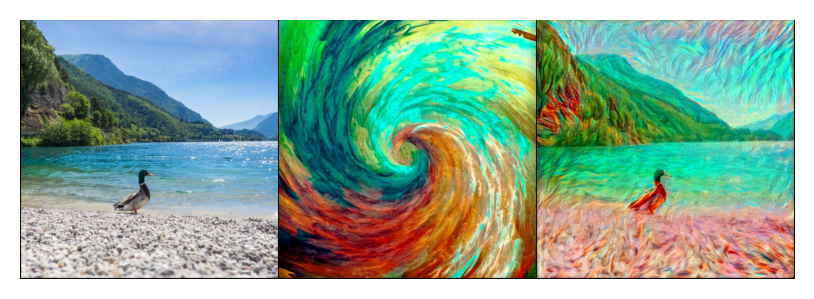

In [33]:
fig = plt.figure(figsize = (5,5), dpi = 200) 
sample = torch.cat((content_image.cpu(), style_image.cpu(), output.cpu()), dim = 0) 
grid = torchvision.utils.make_grid(sample, nrow = 3) 

ax = fig.subplots()
plt.axis('off')
ax.imshow(grid.detach().permute(1,2,0))
plt.show(block = False)